# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random
import math
from sklearn.metrics import silhouette_score
import time
import sys

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


class MyKmeans:
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=300,
                 random_state=None, init='random', min_dist=1e-6):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = n_clusters
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

        if init == 'random':
            self.init = self.init_random
        elif init == 'k-means':
            self.init = self.init_k_means
        else:
            print('{} is not a possible value for init'.format(self.init))

        self.min_dist = min_dist
        self.min_float = sys.float_info.min

    def init_random(self, X):
        # инициализация аналогичная sklearn KMeans
        # "choose k observations (rows) at random from data"
        # нельзя сделать просто np.random.choice, так как
        # центроиды не должны совпадать
        positions = np.arange(X.shape[0])
        np.random.shuffle(positions)
        # это не self.labels
        labels = positions[:self.k]
        return X[labels]

    def init_k_means(self, X):
        centroids = np.empty((self.k, X.shape[1]))
        position = np.random.choice(X.shape[0])
        centroids[0] = X[position]
        for i in range(1, self.k):
            dist = self.euclidean_distance(X, centroids[:i, :])
            min_dist = dist.min(axis=1) ** 2
            weight = min_dist / min_dist.sum()
            # можно не проверять на сопадение со
            # старыми центроидами - для них p = 0
            centroids[i] = X[np.random.choice(X.shape[0], p=weight)]
        return centroids

    def move_centroids(self, X, prev_centroids):
        dist = self.euclidean_distance(X, prev_centroids)
        # это не self.labels
        labels = np.argmin(dist, axis=1)
        new_centroids = [np.mean(X[labels == i], axis=0)
                         for i in range(self.k)]
        return np.array(new_centroids)

    def euclidean_distance(self, X, Y):
        x_sq = (X ** 2).sum(axis=1).reshape(-1, 1)
        y_sq = (Y ** 2).sum(axis=1)
        xy = X @ Y.T
        return (x_sq - 2 * xy + y_sq)

    def dots_distance(self, a):
        return math.sqrt((a ** 2).sum() + self.min_float)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        # ...
        self.centroids = self.init(X)

        for _ in range(self.max_iter):
            new_centroids = self.move_centroids(X, self.centroids)
            if self.dots_distance(new_centroids
                                  - self.centroids) < self.min_dist:
                break
            else:
                self.centroids = new_centroids

        # Переобозначу self.labels, чтобы понимать сделан ли
        # predict для этого fit или нет
        self.labels = None

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = self.euclidean_distance(X, self.centroids)
        self.labels = np.argmin(dist, axis=1)
        return self


class MiniBatchKMeans(MyKmeans):
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=300,
                 random_state=None, init='random', min_dist=1e-6,
                 batch_size=100):
        MyKmeans.__init__(self, n_clusters, metric, max_iter,
                          random_state, init, min_dist)
        self.batch_size = batch_size

    def move_centroids(self, X, prev_centroids, labels, n_batch):
        n_min = (n_batch - 1) * self.batch_size
        n_max = n_batch * self.batch_size
        if n_max >= X.shape[0]:
            n_max = X.shape[0]
        mb_positions = range(n_min, n_max)
        mb = X[mb_positions]
        dist = self.euclidean_distance(mb, prev_centroids)
        labels[mb_positions] = np.argmin(dist, axis=1)
        new_centroids = [np.mean(X[labels == i], axis=0)
                         for i in range(self.k)]
        n_batch = (n_batch + 1) if n_batch < self.n_batch_max else 1
        return np.array(new_centroids)

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = self.init(X)

        dist = self.euclidean_distance(X, self.centroids)
        labels = np.argmin(dist, axis=1)
        n_batch = 1
        self.n_batch_max = X.shape[0] // self.batch_size + 1
        for _ in range(self.max_iter):
            new_centroids = self.move_centroids(X, self.centroids,
                                                labels, n_batch)
            if self.dots_distance(new_centroids
                                  - self.centroids) < self.min_dist:
                break
            else:
                self.centroids = new_centroids

        self.labels = None

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3,
                  cluster_std=1, center_box=(-10.0, 10.0),
                  shuffle=False, random_state=1234)

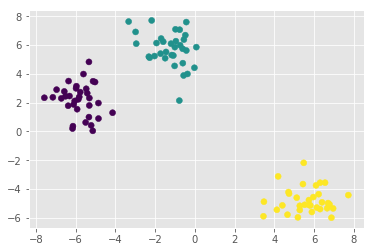

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

In [6]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

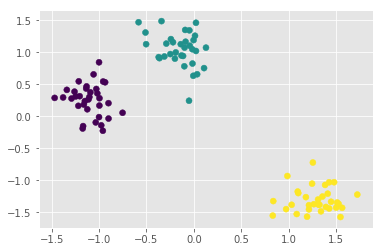

In [7]:
plt.scatter(X_sc[:,0], X_sc[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [8]:
## Работоспособность MyKmeans

In [9]:
random_states = range(100, 1100, 100)

best_score = 0
best_random_state = 0
best_centroids = []
best_labels = []
for random_state in random_states:
    model = MyKmeans(n_clusters=3,
                     random_state=random_state)
    model.fit(X_sc)
    model.predict(X_sc)
    score = silhouette_score(X_sc, model.labels)
    if score > best_score:
        best_score = score
        best_random_state = random_state
        best_centroids = model.centroids
        best_labels = model.labels

print('best silhouette score {}'.format(best_score))
centroids = best_centroids
labels = best_labels

best silhouette score 0.7561453658360859


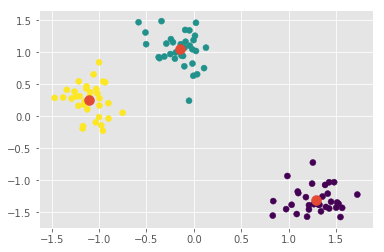

In [10]:
plt.scatter(X_sc[:,0], X_sc[:, 1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], s=100)

In [11]:
## Работоспособность MyKmeans++

In [12]:
random_states = range(100, 1100, 100)

best_score = 0
best_random_state = 0
best_centroids = []
best_labels = []
for random_state in random_states:
    model = MyKmeans(n_clusters=3,
                     init='k-means',
                     random_state=random_state)
    model.fit(X_sc)
    model.predict(X_sc)
    score = silhouette_score(X_sc, model.labels)
    if score > best_score:
        best_score = score
        best_random_state = random_state
        best_centroids = model.centroids
        best_labels = model.labels

print('best silhouette score {}'.format(best_score))
centroids = best_centroids
labels = best_labels

best silhouette score 0.7561453658360859


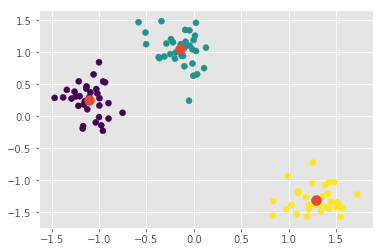

In [13]:
plt.scatter(X_sc[:,0], X_sc[:, 1], c=y)
plt.scatter(centroids[:,0], centroids[:,1], s=100)

In [14]:
## Работоспособность MyKmeans с MiniBatchMyKmeans

In [15]:
random_states = range(100, 1100, 100)

best_score = 0
best_random_state = 0
best_centroids = []
best_labels = []
for random_state in random_states:
    model = MiniBatchKMeans(n_clusters=3,
                            random_state=random_state,
                            batch_size=10)
    model.fit(X_sc)
    model.predict(X_sc)
    score = silhouette_score(X_sc, model.labels)
    if score > best_score:
        best_score = score
        best_random_state = random_state
        best_centroids = model.centroids
        best_labels = model.labels

print('best silhouette score {}'.format(best_score))
centroids = best_centroids
labels = best_labels

best silhouette score 0.7561453658360859


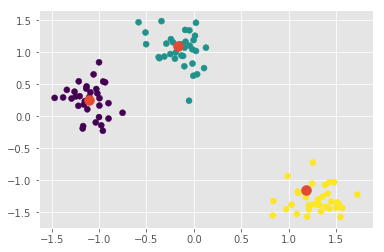

In [16]:
plt.scatter(X_sc[:,0], X_sc[:, 1], c=y)
plt.scatter(centroids[:,0], centroids[:,1], s=100)

In [17]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans

In [18]:
random_states = range(100, 1100, 100)

best_score = 0
best_random_state = 0
best_centroids = []
best_labels = []
for random_state in random_states:
    model = MiniBatchKMeans(n_clusters=3,
                            init='k-means',
                            random_state=random_state,
                            batch_size=10)
    model.fit(X_sc)
    model.predict(X_sc)
    score = silhouette_score(X_sc, model.labels)
    if score > best_score:
        best_score = score
        best_random_state = random_state
        best_centroids = model.centroids
        best_labels = model.labels

print('best silhouette score {}'.format(best_score))
centroids = best_centroids
labels = best_labels

best silhouette score 0.7561453658360859


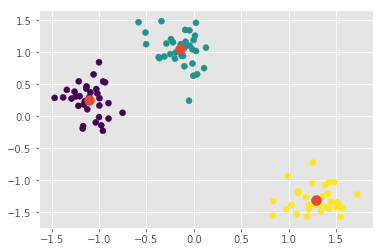

In [19]:
plt.scatter(X_sc[:,0], X_sc[:, 1], c=y)
plt.scatter(centroids[:,0], centroids[:,1], s=100)

In [20]:
## Время выполнения алгоритма Kmeans из sklearn

mean calculation time is 0.01689095973968506


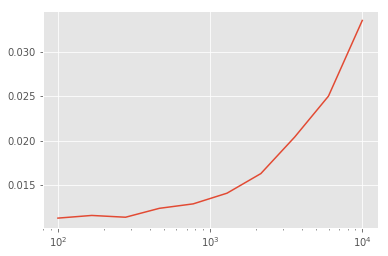

In [21]:
samples = np.logspace(2, 4, 10)
times = np.empty(samples.size)
nexp = 10
for i, samp in enumerate(samples):
    X, y = make_blobs(n_samples=int(samp), n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)

    t_exp = []
    for _ in range(nexp):
        model = KMeans(n_clusters=3)
        t_begin = time.time()
        model.fit(X_sc)
        t_exp.append(time.time() - t_begin)
    times[i] = np.mean(t_exp)

print('mean calculation time is {}'.format(times.mean()))
plt.xscale('log')
plt.plot(samples, times)

In [22]:
## Время выполнения алгоритма MyKmeans

mean calculation time is 0.0025201416015625


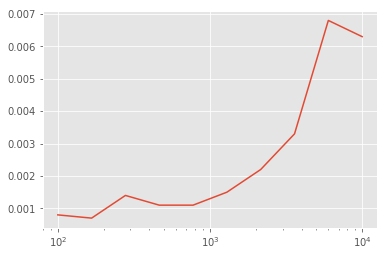

In [23]:
samples = np.logspace(2, 4, 10)
times = np.empty(samples.size)
nexp = 10
for i, samp in enumerate(samples):
    X, y = make_blobs(n_samples=int(samp), n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)

    t_exp = []
    for j in range(nexp):
        model = MyKmeans(n_clusters=3)
        t_begin = time.time()
        model.fit(X_sc)
        t_exp.append(time.time() - t_begin)
    times[i] = np.mean(t_exp)

print('mean calculation time is {}'.format(times.mean()))
plt.xscale('log')
plt.plot(samples, times)

In [24]:
## Время выполнения алгоритма MyKmeans++

mean calculation time is 0.0021801233291625977


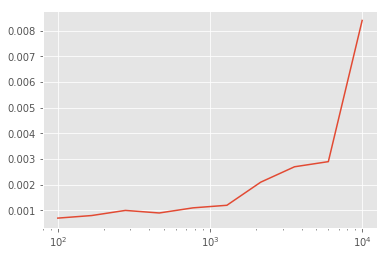

In [25]:
samples = np.logspace(2, 4, 10)
times = np.empty(samples.size)
nexp = 10
for i, samp in enumerate(samples):
    X, y = make_blobs(n_samples=int(samp), n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)

    t_exp = []
    for _ in range(nexp):
        model = MyKmeans(n_clusters=3, init='k-means')
        t_begin = time.time()
        model.fit(X_sc)
        t_exp.append(time.time() - t_begin)
    times[i] = np.mean(t_exp)

print('mean calculation time is {}'.format(times.mean()))
plt.xscale('log')
plt.plot(samples, times)

In [26]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans

mean calculation time is 0.001130061149597168


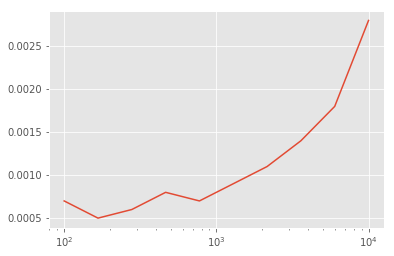

In [27]:
samples = np.logspace(2, 4, 10)
times = np.empty(samples.size)
nexp = 10
for i, samp in enumerate(samples):
    X, y = make_blobs(n_samples=int(samp), n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)

    t_exp = []
    for _ in range(nexp):
        model = MiniBatchKMeans(n_clusters=3,
                                batch_size=int(samp / 20))
        t_begin = time.time()
        model.fit(X_sc)
        t_exp.append(time.time() - t_begin)
    times[i] = np.mean(t_exp)

print('mean calculation time is {}'.format(times.mean()))
plt.xscale('log')
plt.plot(samples, times)

In [28]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans

mean calculation time is 0.0014100861549377441


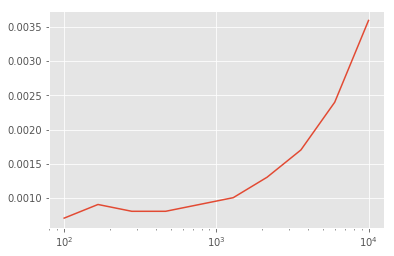

In [29]:
samples = np.logspace(2, 4, 10)
times = np.empty(samples.size)
nexp = 10
for i, samp in enumerate(samples):
    X, y = make_blobs(n_samples=int(samp), n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)

    t_exp = []
    for _ in range(nexp):
        model = MiniBatchKMeans(n_clusters=3, init='k-means',
                                batch_size=int(samp / 20))
        t_begin = time.time()
        model.fit(X_sc)
        t_exp.append(time.time() - t_begin)
    times[i] = np.mean(t_exp)

print('mean calculation time is {}'.format(times.mean()))
plt.xscale('log')
plt.plot(samples, times)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [30]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [31]:
print('Размер таблицы: {}'.format(df_sns.shape))

Размер таблицы: (30000, 40)


In [32]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)

In [33]:
print('Размер таблицы: {}'.format(df_sns.shape))
df_sns.head()

Размер таблицы: (30000, 36)


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [34]:
df_sns.describe().T

,count,mean,std,min,25%,50%,75%,max
basketball,30000.0,0.267333,0.804708,0.0,0.0,0.0,0.0,24.0
football,30000.0,0.252300,0.705357,0.0,0.0,0.0,0.0,15.0
soccer,30000.0,0.222767,0.917226,0.0,0.0,0.0,0.0,27.0
softball,30000.0,0.161200,0.739707,0.0,0.0,0.0,0.0,17.0
volleyball,30000.0,0.143133,0.639943,0.0,0.0,0.0,0.0,14.0
swimming,30000.0,0.134400,0.516990,0.0,0.0,0.0,0.0,31.0
cheerleading,30000.0,0.106633,0.514333,0.0,0.0,0.0,0.0,9.0
baseball,30000.0,0.104933,0.521726,0.0,0.0,0.0,0.0,16.0
tennis,30000.0,0.087333,0.516961,0.0,0.0,0.0,0.0,15.0
sports,30000.0,0.139967,0.471080,0.0,0.0,0.0,0.0,12.0


In [35]:
X = df_sns.values
X_sc = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [36]:
## MyKMeans

In [37]:
%%time
model = MyKmeans(n_clusters=9, random_state=123)
model.fit(X_sc)
model.predict(X_sc)
labels = model.labels
centroids = model.centroids
df_sns.loc[:, 'label'] = labels
df_sns_words = df_sns.iloc[:, 5:]
clusters = df_sns_words.groupby('label').mean()
for k in range(9):
    print('='*10)
    print('cluster label {}'.format(k))
    print(clusters.loc[k].sort_values(ascending=False).head(5))
df_sns = df_sns.drop('label', axis=1)

cluster label 0
hair      3.262758
sex       2.628664
music     2.199783
kissed    1.744843
die       1.296417
Name: 0, dtype: float64
cluster label 1
tennis      4.595833
music       0.841667
god         0.545833
band        0.466667
shopping    0.466667
Name: 1, dtype: float64
cluster label 2
god       5.000000
jesus     2.217391
church    1.861893
bible     1.115090
music     1.099744
Name: 2, dtype: float64
cluster label 3
hollister      1.508918
abercrombie    1.171225
shopping       0.927467
music          0.922711
hair           0.919144
Name: 3, dtype: float64
cluster label 4
baseball    0.867024
music       0.792986
sports      0.654165
god         0.447638
hair        0.416951
Name: 4, dtype: float64
cluster label 5
music       0.709534
shopping    0.514412
god         0.505543
hair        0.451220
dance       0.424612
Name: 5, dtype: float64
cluster label 6
band        4.882960
marching    1.557659
music       1.382100
god         0.547332
dance       0.475043
Name: 6, dtype

In [38]:
## MyKMeans++

In [39]:
%%time
model = MyKmeans(n_clusters=9, init='k-means', random_state=123)
model.fit(X_sc)
model.predict(X_sc)
labels = model.labels
centroids = model.centroids
df_sns.loc[:, 'label'] = labels
df_sns_words = df_sns.iloc[:, 5:]
clusters = df_sns_words.groupby('label').mean()
for k in range(9):
    print('='*10)
    print('cluster label {}'.format(k))
    print(clusters.loc[k].sort_values(ascending=False).head(5))
df_sns = df_sns.drop('label', axis=1)

cluster label 0
hair      3.285556
sex       2.707778
music     2.255556
kissed    1.820000
die       1.124444
Name: 0, dtype: float64
cluster label 1
blonde    327.0
sex        22.0
hair       12.0
god        10.0
drunk       6.0
Name: 1, dtype: float64
cluster label 2
death    1.299948
music    0.846912
god      0.625843
hair     0.448884
die      0.418267
Name: 2, dtype: float64
cluster label 3
dance       1.227629
music       1.174354
shopping    0.999539
cute        0.930120
band        0.813192
Name: 3, dtype: float64
cluster label 4
music       0.532052
god         0.304195
dance       0.211792
hair        0.184281
shopping    0.174148
Name: 4, dtype: float64
cluster label 5
hollister      1.505226
abercrombie    1.169570
shopping       0.936121
hair           0.931475
music          0.925668
Name: 5, dtype: float64
cluster label 6
god       52.0
jesus     30.0
bible     11.0
death      1.0
church     1.0
Name: 6, dtype: float64
cluster label 7
god       3.631879
jesus     1.533

In [40]:
## MyKMeans с MiniBatchMyKMeans

In [41]:
%%time
model = MiniBatchKMeans(n_clusters=9, random_state=123)
model.fit(X_sc)
model.predict(X_sc)
labels = model.labels
centroids = model.centroids
df_sns.loc[:, 'label'] = labels
df_sns_words = df_sns.iloc[:, 5:]
clusters = df_sns_words.groupby('label').mean()
for k in range(9):
    print('='*10)
    print('cluster label {}'.format(k))
    print(clusters.loc[k].sort_values(ascending=False).head(5))
df_sns = df_sns.drop('label', axis=1)

cluster label 0
hair       2.137479
music      1.508272
sex        1.491728
clothes    1.017684
die        0.989161
Name: 0, dtype: float64
cluster label 1
tennis      4.567347
music       0.857143
god         0.546939
shopping    0.493878
band        0.481633
Name: 1, dtype: float64
cluster label 2
god       6.566667
jesus     4.238095
church    1.309524
music     1.285714
bible     0.866667
Name: 2, dtype: float64
cluster label 3
hair     2.489764
hot      1.935433
music    1.889764
cute     1.666142
dance    1.486614
Name: 3, dtype: float64
cluster label 4
music       1.047092
god         0.720851
church      0.584397
dance       0.540426
shopping    0.433475
Name: 4, dtype: float64
cluster label 5
sports      1.171082
music       1.009934
mall        0.801325
shopping    0.696468
hair        0.657837
Name: 5, dtype: float64
cluster label 6
band        6.090909
marching    1.595455
music       1.545455
dance       0.602273
god         0.586364
Name: 6, dtype: float64
cluster label 7

In [42]:
## MyKMeans++ с MiniBatchMyKMeans

In [43]:
%%time
model = MiniBatchKMeans(n_clusters=9, init='k-means', random_state=123)
model.fit(X_sc)
model.predict(X_sc)
labels = model.labels
centroids = model.centroids
df_sns.loc[:, 'label'] = labels
df_sns_words = df_sns.iloc[:, 5:]
clusters = df_sns_words.groupby('label').mean()
for k in range(9):
    print('='*10)
    print('cluster label {}'.format(k))
    print(clusters.loc[k].sort_values(ascending=False).head(5))
df_sns = df_sns.drop('label', axis=1)

cluster label 0
hair     3.917098
sex      2.869171
music    2.788860
dance    2.203368
rock     1.650259
Name: 0, dtype: float64
cluster label 1
blonde    327.0
sex        22.0
hair       12.0
god        10.0
drunk       6.0
Name: 1, dtype: float64
cluster label 2
die      12.117647
death     1.470588
god       1.117647
dance     1.117647
hair      1.058824
Name: 2, dtype: float64
cluster label 3
music       1.398150
hair        0.856640
shopping    0.827131
mall        0.813037
god         0.674081
Name: 3, dtype: float64
cluster label 4
music       0.540673
god         0.373773
dance       0.321137
shopping    0.237893
cute        0.230262
Name: 4, dtype: float64
cluster label 5
cute         3.612069
shopping     1.396552
hair         1.362069
hollister    1.198276
music        1.149425
Name: 5, dtype: float64
cluster label 6
god       52.0
jesus     30.0
bible     11.0
death      1.0
church     1.0
Name: 6, dtype: float64
cluster label 7
god       11.075472
jesus      6.962264
bibl

In [44]:
## Вывод

Результаты получились довольно похожими для разных вариаций. Вообще говоря, KMeans довольно рандомный метод и для сравнения надо бы побольше статистики набрать. Не очень понятно по каким критериям тут оценивать что лучше, а что хуже. Силуэт у меня завис при попытке применения. По скорости видно, что варианты с minibatch значительно быстрее, чем без него.